In [ ]:
# importing libraries and modules
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time

#1

In [ ]:
# Selected 3 stocks that belong to the same industry according to wikipedia and compiled here: https://drive.google.com/file/d/1jbZScIpPNJWl6ZNAcksPK5tS1l8yOwDs/view?usp=sharing
tickers = ['A', 'ABT', 'BAX']
names = ['Agilent Technologies', 'Abbott', 'Baxter International']
cols = ['open', 'high', 'low', 'close', 'volume']

# reading their stock price data
dfs = [pd.read_csv(f"drive/MyDrive/EE782/data/{ticker}_1min.txt", names=['dt']+cols) for ticker in tickers[:3]]
for i in range(3):
    # converting the data and time information in the dataframe to datetime object for utility
    dfs[i].dt = dfs[i].dt.apply(pd.to_datetime)
    # selecting only those datapoints that lie within the trading hours
    dfs[i] = dfs[i].loc[dfs[i].dt.apply(lambda x: datetime.time(9, 30) <= x.time() <= datetime.time(16, 0))]
    # adding some required fields to the data like date, time, and year
    dfs[i]['date'] = dfs[i].dt.apply(lambda x: x.date())
    dfs[i]['year'] = dfs[i].date.apply(lambda x: x.year)
    dfs[i]['time'] = dfs[i].dt.apply(lambda x: x.time())
    dfs[i].reset_index(drop=True, inplace=True)
    # saving this dataframe for quick analysis later on
    dfs[i].to_feather(f"drive/MyDrive/EE782/data/{tickers[i]}.feather")

In [ ]:
# reading the data for a few stocks
dfs = [pd.read_feather(f"drive/MyDrive/EE782/data/{tickers}.feather") for ticker in tickers]

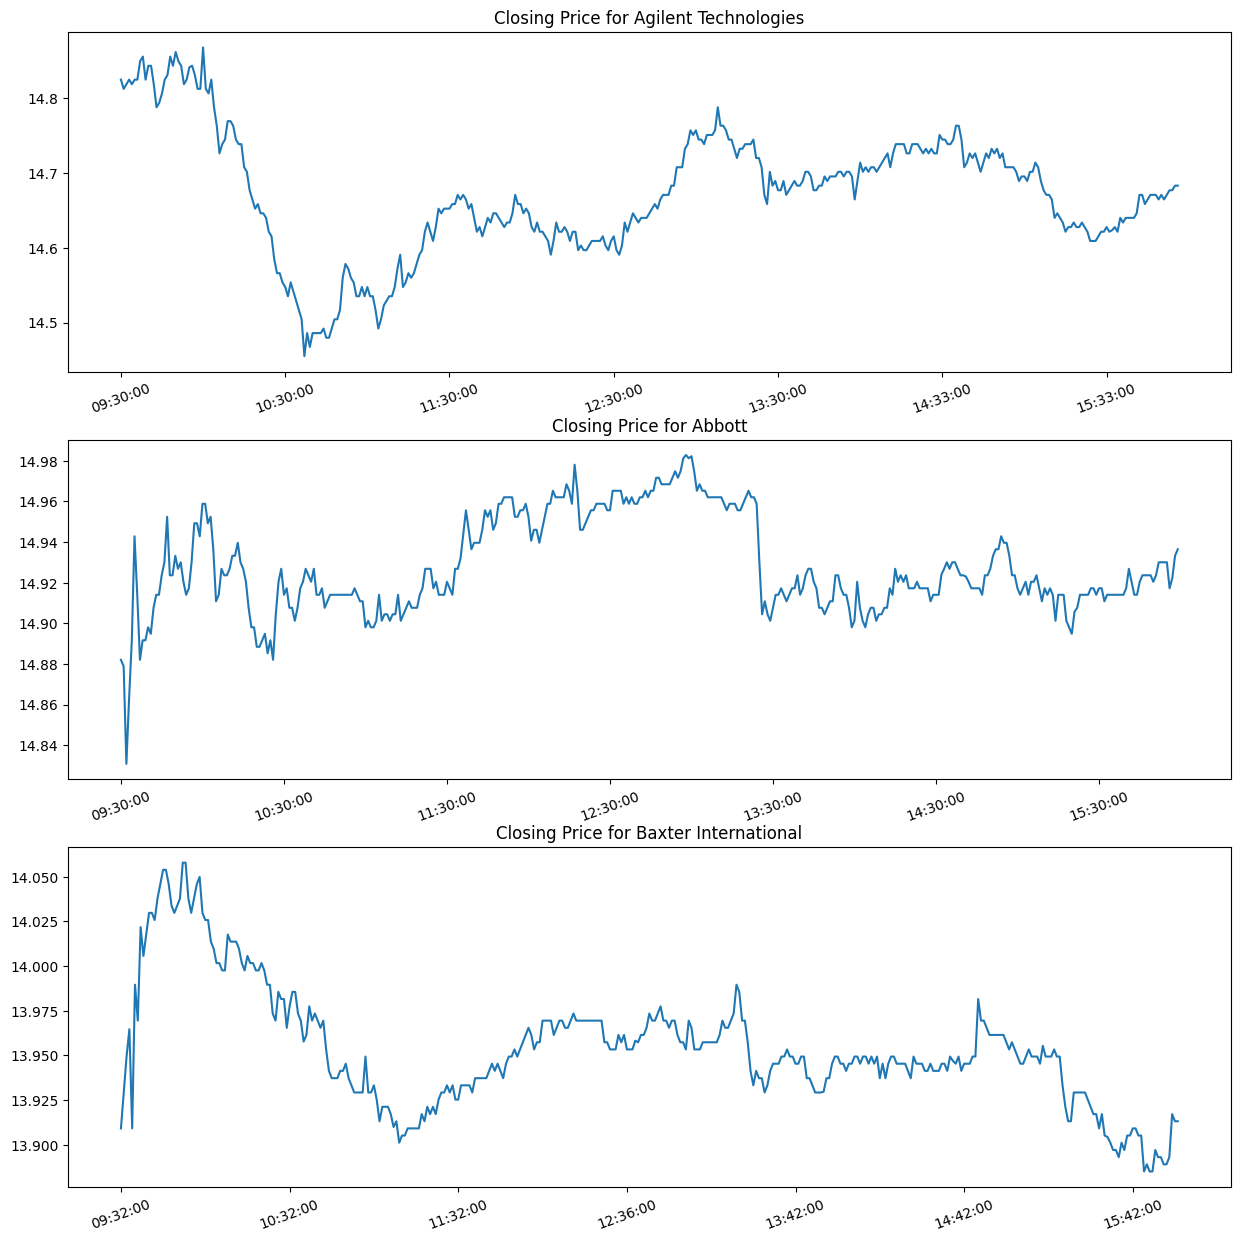

In [ ]:
# plotting the minute-by-minute closing price
fig = plt.figure(figsize=(15, 15))
for i in range(3):
    # selecting just the time and closing price columns for the first date present in the data
    _ = dfs[i][dfs[i].date == dfs[i].iloc[0].date][['time', 'close']]
    fig.add_subplot(3, 1, i+1)
    # plotting that versus time
    plt.plot(_.time.apply(lambda x: str(x)), _.close)
    plt.xticks(_.time[::60].apply(lambda x: str(x)), rotation=20)
    plt.title(f"Closing Price for {names[i]}")
plt.show()

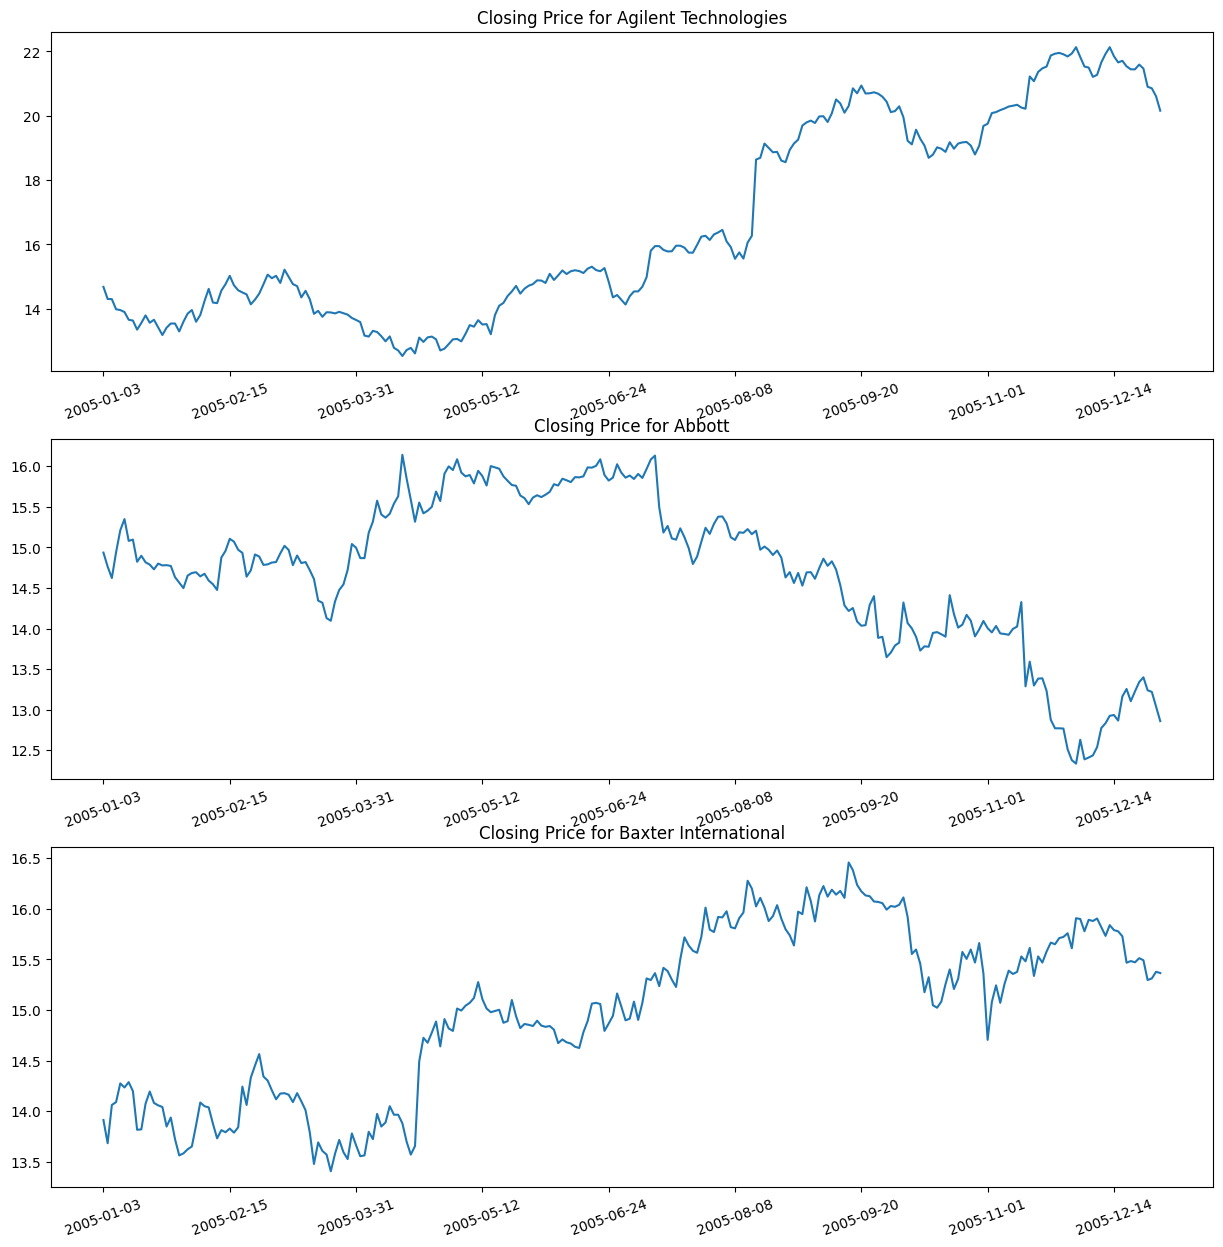

In [ ]:
# plotting the day-by-day closing price for a few stocks
fig = plt.figure(figsize=(15, 15))
for i in range(3):
    # selecting just the date and close columns of the data and the last entry for each day (~4p.m.)
    _ = dfs[i].groupby(dfs[i].date).last().reset_index()[['date', 'close']]
    # selecting only the first year of data present
    _ = _[_.date.apply(lambda x: x.year == _.date.iloc[0].year)]
    fig.add_subplot(3, 1, i+1)
    # plotting that aginst the date
    plt.plot(_.date.apply(lambda x: str(x)), _.close)
    plt.xticks(_.date[::30].apply(lambda x: str(x)), rotation=20)
    plt.title(f"Closing Price for {names[i]}")
plt.show()

In [ ]:
# source : https://stackoverflow.com/questions/64689342/plotly-how-to-add-volume-to-a-candlestick-chart
# plotting the minute-by-minute candlestick chart for a few stocks
for i in range(3):
    # selecting the data from the first date present
    d = dfs[i][dfs[i].date.apply(lambda x: x == dfs[i].date.iloc[0])]
    # we need a secondary y axis to display volume
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # plotting the volume
    fig.add_trace(go.Bar(x=d.dt, y=d.volume),
                secondary_y=False)
    fig.update_traces(opacity=0.8)
    # plotting the candlestick chart
    fig.add_trace(go.Candlestick(x=d.dt,
                    open=d.open, high=d.high,
                    low=d.low, close=d.close),
                secondary_y=True)
    fig.update_layout(
        xaxis_rangeslider_visible=False,
        title=f"Candlestick chart for {names[i]}",
        yaxis_title='Volume/Closing price',
        xaxis_title='Date/Time',
        showlegend=False
        )
    fig.layout.yaxis2.showgrid=False
    fig.show()

#2

In [ ]:
# function to normalize the data such that it has zero mean and unit variance
def norm_scale(df):
    scaler = StandardScaler()
    df[cols] = pd.DataFrame(data=scaler.fit_transform(df[cols]), columns=cols)
    return scaler, df
# function to normalize the data such that it has zero as its min value and one as its max value
def min_max_scale(df):
    scaler = MinMaxScaler()
    df[cols] = pd.DataFrame(data=scaler.fit_transform(df[cols]), columns=cols)
    return scaler, df
# function to apply the inverse of the scaling method performed
def inv_scale(scaler, df):
    df[cols] = pd.DataFrame(data=scaler.inverse_transform(df[cols]), columns=cols)
    return df

In [ ]:
# checking the description of the unnormalized data
df1 = dfs[0].copy()
df1.describe()

,open,high,low,close,volume,year
count,1.659361e+06,1.659361e+06,1.659361e+06,1.659361e+06,1.659361e+06,1.659361e+06
mean,4.472868e+01,4.474365e+01,4.471351e+01,4.472850e+01,7.922647e+03,2.013057e+03
std,3.435758e+01,3.436714e+01,3.434761e+01,3.435720e+01,1.696315e+04,4.944125e+00
min,8.036500e+00,8.043000e+00,7.847100e+00,7.938500e+00,1.000000e+00,2.005000e+03
25%,2.195340e+01,2.196150e+01,2.194200e+01,2.195340e+01,1.600000e+03,2.009000e+03
50%,3.178680e+01,3.179330e+01,3.177370e+01,3.178510e+01,3.800000e+03,2.013000e+03
75%,6.193740e+01,6.195360e+01,6.191990e+01,6.193450e+01,8.668000e+03,2.017000e+03
max,1.790907e+02,1.791108e+02,1.790459e+02,1.791108e+02,2.366740e+06,2.022000e+03


In [ ]:
# normalizing it to and verifying that it has ~zero mean and unit variance
sc1, df1 = norm_scale(df1)
df1.describe()

,open,high,low,close,volume,year
count,1.659361e+06,1.659361e+06,1.659361e+06,1.659361e+06,1.659361e+06,1.659361e+06
mean,-6.555268e-16,-2.718573e-16,-6.642964e-16,-7.278759e-16,5.741341e-17,2.013057e+03
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.944125e+00
min,-1.067950e+00,-1.067900e+00,-1.073333e+00,-1.070809e+00,-4.669917e-01,2.005000e+03
25%,-6.628897e-01,-6.629053e-01,-6.629724e-01,-6.628918e-01,-3.727285e-01,2.009000e+03
50%,-3.766820e-01,-3.768238e-01,-3.767312e-01,-3.767304e-01,-2.430355e-01,2.013000e+03
75%,5.008714e-01,5.007677e-01,5.009487e-01,5.007977e-01,4.393957e-02,2.017000e+03
max,3.910696e+00,3.909758e+00,3.910968e+00,3.911330e+00,1.390554e+02,2.022000e+03


In [ ]:
# applying the inverse scaling to obtain the orginal data
df1 = inv_scale(sc1, df1)
df1.describe()

,open,high,low,close,volume,year
count,1.659361e+06,1.659361e+06,1.659361e+06,1.659361e+06,1.659361e+06,1.659361e+06
mean,4.472868e+01,4.474365e+01,4.471351e+01,4.472850e+01,7.922647e+03,2.013057e+03
std,3.435758e+01,3.436714e+01,3.434761e+01,3.435720e+01,1.696315e+04,4.944125e+00
min,8.036500e+00,8.043000e+00,7.847100e+00,7.938500e+00,1.000000e+00,2.005000e+03
25%,2.195340e+01,2.196150e+01,2.194200e+01,2.195340e+01,1.600000e+03,2.009000e+03
50%,3.178680e+01,3.179330e+01,3.177370e+01,3.178510e+01,3.800000e+03,2.013000e+03
75%,6.193740e+01,6.195360e+01,6.191990e+01,6.193450e+01,8.668000e+03,2.017000e+03
max,1.790907e+02,1.791108e+02,1.790459e+02,1.791108e+02,2.366740e+06,2.022000e+03


In [ ]:
# scaling and verifying the min-max scaling on the data
sc1, df1 = min_max_scale(df1)
df1.describe()

,open,high,low,close,volume,year
count,1.659361e+06,1.659361e+06,1.659361e+06,1.659361e+06,1.659361e+06,1.659361e+06
mean,2.145061e-01,2.145386e-01,2.153427e-01,2.149296e-01,3.347072e-03,2.013057e+03
std,2.008579e-01,2.008978e-01,2.006300e-01,2.007171e-01,7.167308e-03,4.944125e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.005000e+03
25%,8.135959e-02,8.136248e-02,8.233060e-02,8.187598e-02,6.756132e-04,2.009000e+03
50%,1.388466e-01,1.388356e-01,1.397592e-01,1.393134e-01,1.605162e-03,2.013000e+03
75%,3.151101e-01,3.151417e-01,3.158480e-01,3.154482e-01,3.662001e-03,2.017000e+03
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.022000e+03


I would be using the min-max scaling method because in the norm scaling we have negative values for the features which doesn't make sense for the task we at hand (predicting prices).

#3

(a) Decision for trading will be taken based on every datapoint available so it may be called somewhat high-frequency trading.

(b) buy-ask spread is 13-18% for S&P 500 companies. I have taken it as 15%. The commission charged by Zerodha is 20 Rs. or 0.03% whichever is lower. I have taken it as 0.03%.

(c) I will trade only one stock at a time for brevity however, I will run tests/simulations on a few stocks, seperately for each.

#4

In [ ]:
# defining the custom model LSTM module
class Model(nn.Module):
    # initialization
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        # required since we inherit from another class
        super().__init__()
        # adding the lstm layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # adding a linear layer to get the single output
        self.out = nn.Linear(hidden_size, output_size)

    # forward pass of the model
    def forward(self, input):
        # generating the LSTM hidden state
        _ = self.lstm(input)
        # returning the final prediction for the dense layer
        return self.out(_[1][0][-1])

#5

In [ ]:
# defining the custom dataset
class SingleStock(Dataset):
    def __init__(self, df, seq_len, t_skip):
        super().__init__()
        # the dataframe is supplied
        self.df = df
        # seq_len is how many past samples to consider as part of the sequence
        self.seq_len = seq_len
        # the time to look forward to in the future for e.g. 10 for predicting price 10 minutes later
        self.t_skip = t_skip

    def __len__(self):
        # the length will depend on the t_skip, we cannot have closing prices outside of our dataset
        return len(self.df) - self.seq_len - self.t_skip + 1

    def __getitem__(self, idx):
        # outputs should be torch tensors
        # x is the tensor containing the feature (open, high, low, close, and volume)
        x = torch.tensor(self.df.iloc[idx:idx + self.seq_len].values, dtype=torch.float32)
        # y is the tensor containing the closing price t_skip into the future
        y = torch.tensor(self.df.close[idx + self.seq_len + self.t_skip - 1], dtype=torch.float32)
        return x, y


# funtion to generate seperate datasets for training and testing
def gen_single_dataset(df, num_years_test=2, seq_len=100, t_skip=1):
    # taking the first years for training
    train = df[cols][df.year.apply(lambda x: df.year.iloc[-1] - x >= num_years_test)]
    sc_train, train = min_max_scale(train)
    # taking the last num_years for testing
    test = df[cols][df.year.apply(lambda x: df.year.iloc[-1] - x < num_years_test)].reset_index(drop=True)
    sc_test, test = min_max_scale(test)
    return sc_train, SingleStock(train, seq_len, t_skip), sc_test, SingleStock(test, seq_len, t_skip)


# funtion to only generate the test dataset
def gen_single_dataset_test(df, num_years_test=2, seq_len=100, t_skip=1):
    test = df[cols][df.year.apply(lambda x: df.year.iloc[-1] - x < num_years_test)].reset_index(drop=True)
    sc_test, test = min_max_scale(test)
    return sc_test, SingleStock(test, seq_len, t_skip)

#6

In [ ]:
# loading the data for a few stocks
df = [pd.read_feather(f"drive/MyDrive/EE782/data/{ticker}.feather") for ticker in tickers]
# generating the custom dataset for one of them
sc_train, dataset_train, sc_test, dataset_test = gen_single_dataset(df[0])
# creating the dataloader
dataloader_train = DataLoader(dataset=dataset_train, batch_size=8192*2)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=8192*2)
len_train, len_test = len(dataset_train), len(dataset_test)

In [ ]:
# function for training the model and returning the loss per epoch
def train(model, loss_fn, optimizer, max_epochs, dataloader_train, dataloader_test, PATH)
    # for storing the loss values
    loss_per_epoch_train, loss_per_epoch_val = [], []

    # start training loop
    for epoch in range(max_epochs):
        loss_curr_train = 0
        print(f'Epoch {epoch+1}/{max_epochs}', end=" ")

        model.train()
        start = time.time()
        for i, (x, y) in enumerate(dataloader_train):
            # reset optimizer gradients
            optimizer.zero_grad()
            # generate model predictions
            pred = model(x)
            # compute  and store the loss
            loss = loss_fn(pred, y.reshape(-1, 1))
            loss_curr_train += loss.item()
            # compute the derivatives
            loss.backward()
            # update the parameters i.e. the weights
            optimizer.step()
        end = time.time()
        print(end-start)

        loss_per_epoch_train.append(loss_curr_train/len_train)
        loss_curr_val = 0

        # for validation loss
        model.eval()
        with torch.no_grad():
            for i, (x, y) in enumerate(dataloader_test):
                pred = model(x)
                loss = loss_fn(pred, y.reshape(-1, 1))
                loss_curr_val += loss.item()
        loss_per_epoch_val.append(loss_curr_val/len_test)

        # for saving the model
        torch.save(model.state_dict(), PATH + str(epoch))

    return loss_per_epoch_train, loss_per_epoch_val

In [ ]:
# path for storing the trained model or load a previously trained model
PATH = "drive/MyDrive/EE782/models/model-1-epoch-"
model = Model(input_size=len(cols), output_size=1, hidden_size=20, num_layers=2)
# we will be using MSE loss and adam optimizer
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())
# training epochs
max_epochs = 10
# training
loss_per_epoch_train, loss_per_epoch_val = train(model, loss_fn, optimizer, max_epochs, dataloader_train, dataloader_test, PATH)

Epoch 1/10 936.2518475055695
Epoch 2/10 812.561606168747
Epoch 3/10 806.4887943267822
Epoch 4/10 804.5625586509705
Epoch 5/10 823.8241620063782
Epoch 6/10 808.3814961910248
Epoch 7/10 810.0989675521851
Epoch 8/10 793.9581723213196
Epoch 9/10 794.9206595420837
Epoch 10/10 800.0065591335297


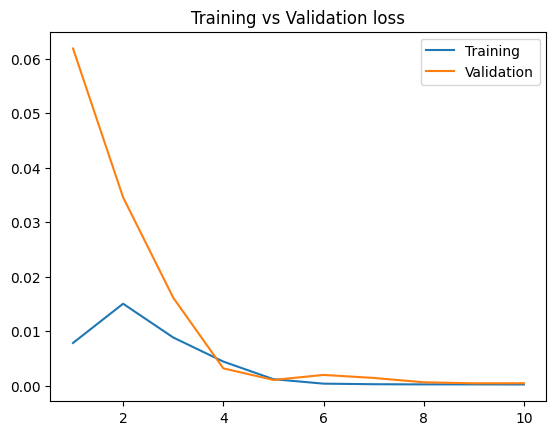

In [ ]:
# plotting the training and validation loss versus epochs
plt.plot(range(1, max_epochs+1), loss_per_epoch_train, label="Training")
plt.plot(range(1, max_epochs+1), loss_per_epoch_val, label="Validation")
plt.legend()
plt.title("Training vs Validation loss")
plt.show()

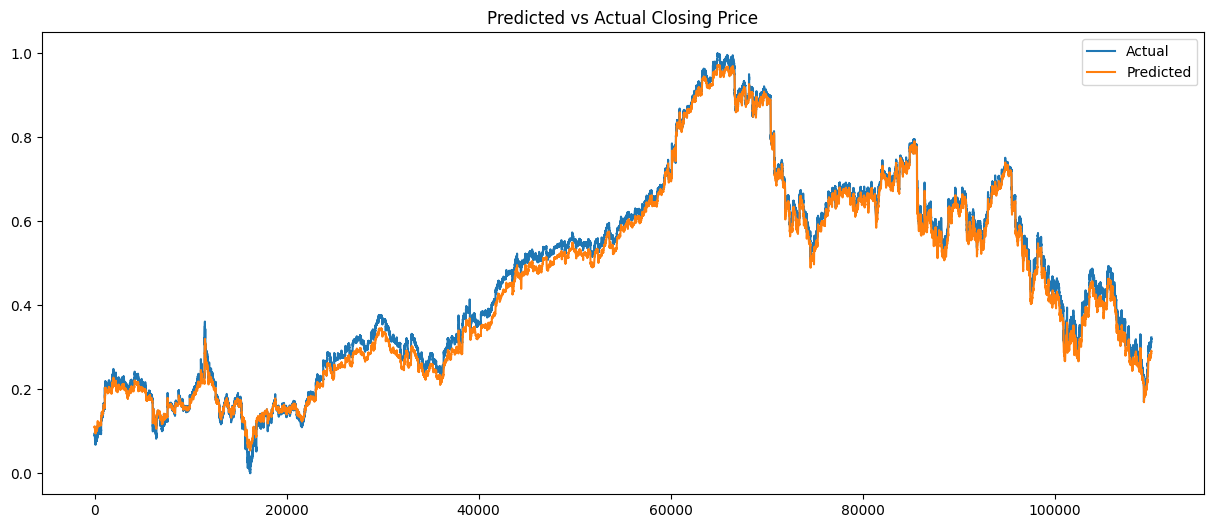

In [ ]:
# plotting the predicted vs actual price for the stock on which the model was trained
pred = []
y = []
model.eval()
with torch.no_grad():
    for i, (x, y_) in enumerate(dataloader_test):
        pred.extend(list(model(x).detach().numpy()))
        y.extend(list(y_))
fig = plt.figure(figsize=(15, 6))
plt.plot(y, label="Actual")
plt.plot(pred, label="Predicted")
plt.legend()
plt.title("Predicted vs Actual Closing Price")
plt.show()

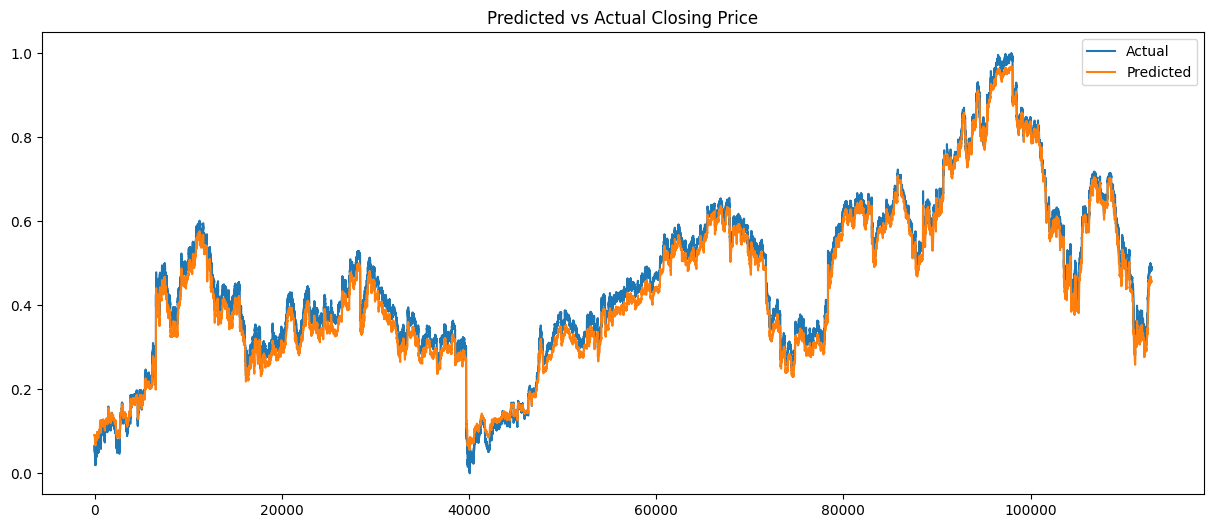

In [ ]:
# generating the dataloader for a different stock
dataloader_test_1 = DataLoader(dataset=gen_single_dataset(df[1])[-1], batch_size=8192*2)
# seeing if the model trained on one stock can predict the price of another stock which it has never seen but it is in the same industry
pred = []
y = []
model.eval()
with torch.no_grad():
    for i, (x, y_) in enumerate(dataloader_test_1):
        pred.extend(list(model(x).detach().numpy()))
        y.extend(list(y_))
fig = plt.figure(figsize=(15, 6))
plt.plot(y, label="Actual")
plt.plot(pred, label="Predicted")
plt.legend()
plt.title("Predicted vs Actual Closing Price")
plt.show()

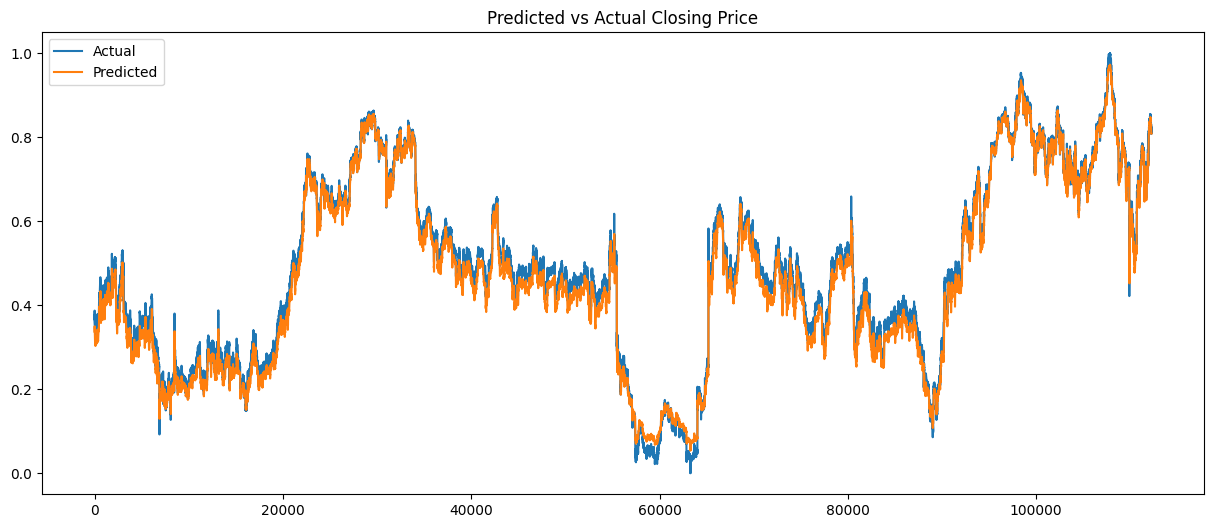

In [ ]:
dataloader_test_1 = DataLoader(dataset=gen_single_dataset(df[2])[-1], batch_size=8192*2)
pred = []
y = []
model.eval()
with torch.no_grad():
    for i, (x, y_) in enumerate(dataloader_test_1):
        pred.extend(list(model(x).detach().numpy()))
        y.extend(list(y_))
fig = plt.figure(figsize=(15, 6))
plt.plot(y, label="Actual")
plt.plot(pred, label="Predicted")
plt.legend()
plt.title("Predicted vs Actual Closing Price")
plt.show()

In [ ]:
# training the modeel that predicts the price 10 minutes into the future

sc_train, dataset_train, sc_test, dataset_test = gen_single_dataset(df[0], t_skip=10)
dataloader_train = DataLoader(dataset=dataset_train, batch_size=8192*2)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=8192*2)
len_train, len_test = len(dataset_train), len(dataset_test)

PATH = "drive/MyDrive/EE782/models/model-2-epoch-"
ar_model = Model(input_size=len(cols), output_size=1, hidden_size=20, num_layers=2)

loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(ar_model.parameters())
max_epochs = 10
loss_per_epoch_train, loss_per_epoch_val = train(ar_model, loss_fn, optimizer, max_epochs, dataloader_train, dataloader_test, PATH)

Epoch 1/10 2107.5478553771973
Epoch 2/10 1758.964712381363
Epoch 3/10 2071.228847503662
Epoch 4/10 1665.6825881004333
Epoch 5/10 1652.683069229126
Epoch 6/10 1638.386922121048
Epoch 7/10 1620.0484313964844
Epoch 8/10 1630.3093438148499
Epoch 9/10 1615.7404792308807
Epoch 10/10 1626.414065361023


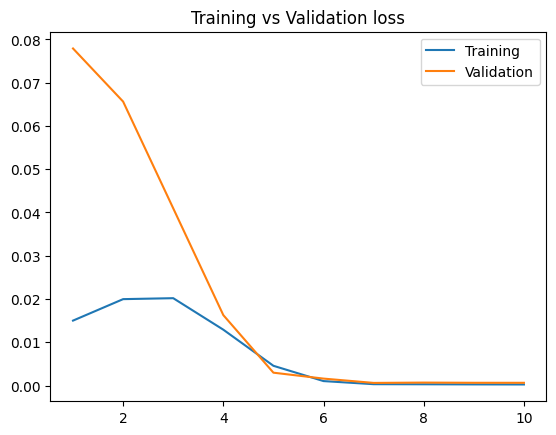

In [ ]:
plt.plot(range(1, max_epochs+1), loss_per_epoch_train, label="Training")
plt.plot(range(1, max_epochs+1), loss_per_epoch_val, label="Validation")
plt.legend()
plt.title("Training vs Validation loss")
plt.show()

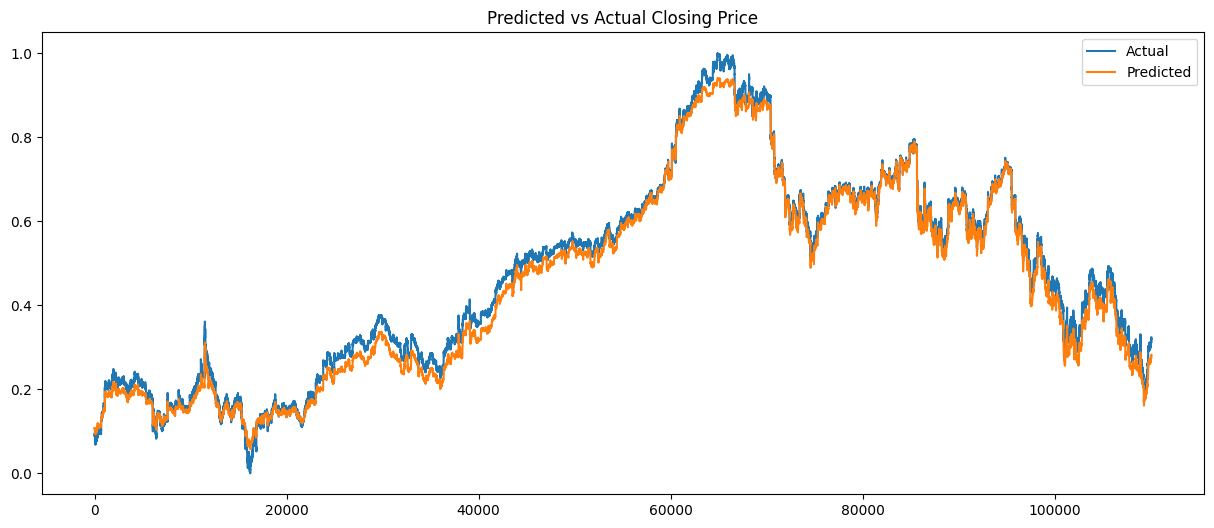

In [ ]:
pred = []
y = []
ar_model.eval()
with torch.no_grad():
    for i, (x, y_) in enumerate(dataloader_test):
        pred.extend(list(ar_model(x).detach().numpy()))
        y.extend(list(y_))
fig = plt.figure(figsize=(15, 6))
plt.plot(y, label="Actual")
plt.plot(pred, label="Predicted")
plt.legend()
plt.title("Predicted vs Actual Closing Price")
plt.show()

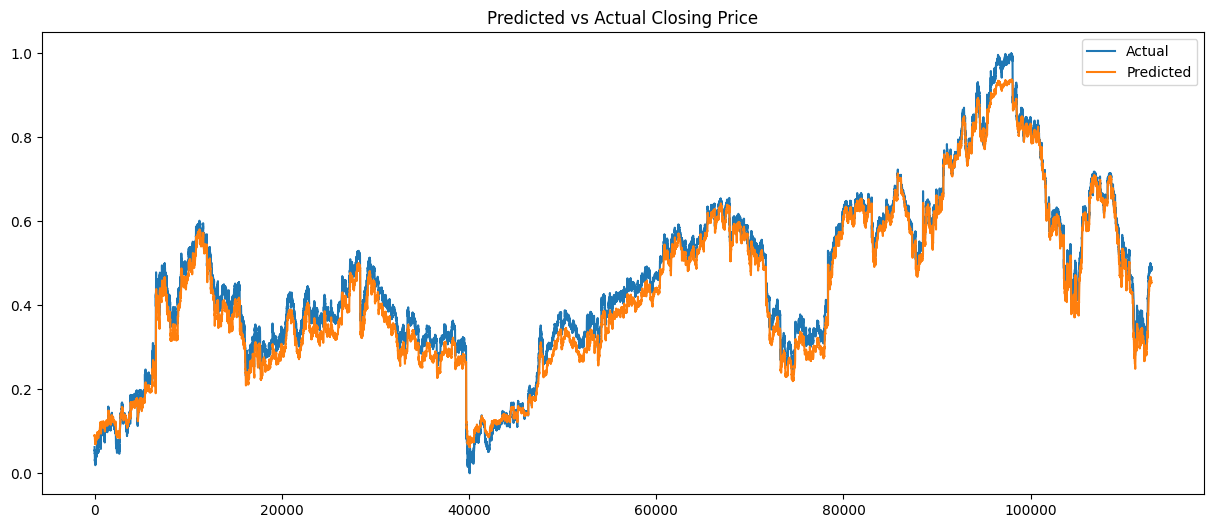

In [ ]:
dataloader_test_1 = DataLoader(dataset=gen_single_dataset(df[1], t_skip=10)[-1], batch_size=8192*2)
pred = []
y = []
ar_model.eval()
with torch.no_grad():
    for i, (x, y_) in enumerate(dataloader_test_1):
        pred.extend(list(ar_model(x).detach().numpy()))
        y.extend(list(y_))
fig = plt.figure(figsize=(15, 6))
plt.plot(y, label="Actual")
plt.plot(pred, label="Predicted")
plt.legend()
plt.title("Predicted vs Actual Closing Price")
plt.show()

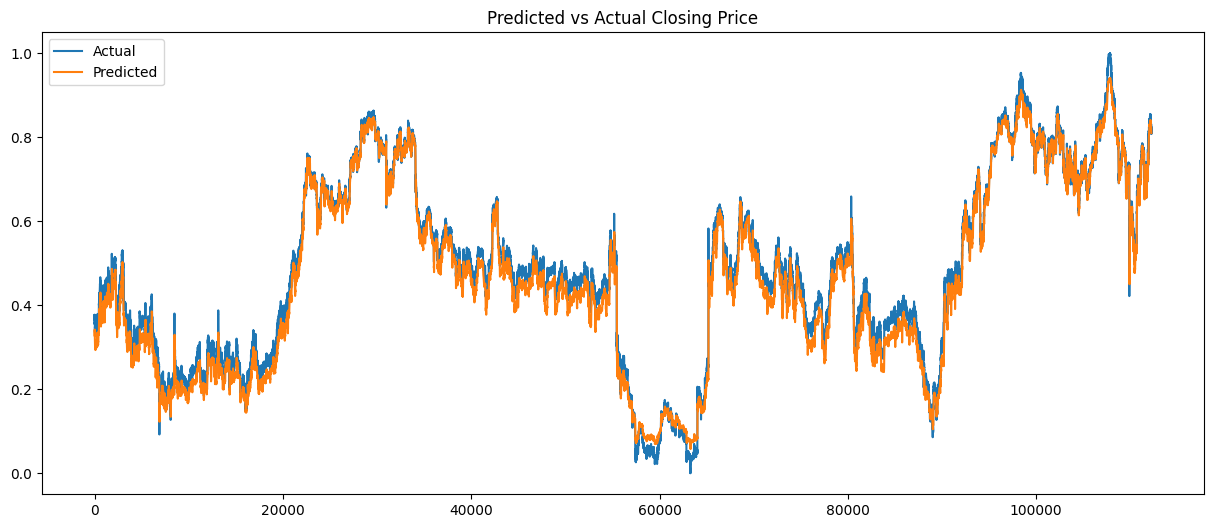

In [ ]:
dataloader_test_1 = DataLoader(dataset=gen_single_dataset(df[2], t_skip=10)[-1], batch_size=8192*2)
pred = []
y = []
ar_model.eval()
with torch.no_grad():
    for i, (x, y_) in enumerate(dataloader_test_1):
        pred.extend(list(ar_model(x).detach().numpy()))
        y.extend(list(y_))
fig = plt.figure(figsize=(15, 6))
plt.plot(y, label="Actual")
plt.plot(pred, label="Predicted")
plt.legend()
plt.title("Predicted vs Actual Closing Price")
plt.show()

#7

In [ ]:
# function to calculate the actual closing prices from the scaled ones
def inverse_scale(scaler, value):
    min = scaler.data_min_[-2]
    scale = scaler.data_max_[-2] - min
    return scale * value + min

# function that decides whether to buy or sell or hold
def decision(cur, next, next10, tolerance):
    # price will increase
    if next > cur:
        # price will continue to increase 10 minutes in the future
        if next10 > next:
            return "buy"
        # price may stay steady
        elif next10 > next * (1 - tolerance):
            return "hold"
        # price only rises temporarily but falls in the near future
        else:
            return "sell"

    # vice-versa
    elif next <= cur:
        if next10 > next * (1 + tolerance):
            return "buy"
        elif next10 > next:
            return "hold"
        else:
            return "sell"

# function to calculate the effective price after adjusting for the bid-ask spread and the commision
def price_calc(buy, price, spread, comm):
    fees = price * (spread + comm)
    # we pay more while buying and get less when selling
    return price + fees if buy else price - fees

# function to implement the trading action
def trade(money, holdings, action, price, spread, comm):
    # no change
    if action == "hold":
        return money, holdings
    # money decreases, holdings increase
    elif action == "buy":
        price = price_calc(buy=True, price=price, spread=spread, comm=comm)
        # insufficient funds
        if money < price:
            return money, holdings
        else:
            return money - price, holdings + 1
    # money increase, holdings decrease
    else:
        price = price_calc(buy=False, price=price, spread=spread, comm=comm)


        # only one of the two shorting methods is used at a time
        # i.e. only one of them is uncommented while executing
        # the results for both are shown seperately

        # infinite shorting
        # return money + price, holdings - 1

        # limited shorting
        if holdings > -10:
            return money + price, holdings - 1
        else:
            return money, holdings

In [ ]:
# the trading module that will return the profits made by the algorithm and a simple buy and hold strategy
def trading_module(money, holdings, scaler, dataset_next, model_next, model_next10, tolerance=0.1, spread=0.15, comm=0.0003):
    initial_money = money
    for i in range(len(dataset_next)):
        features, price = dataset_next[i]
        # predict the prices
        next = model_next(features)
        next10 = model_next10(features)
        # get the actual values
        price, next, next10 = map(lambda x: inverse_scale(scaler, x), (price, next, next10))
        # take trading decision
        action = decision(price, next, next10, tolerance=tolerance)
        # execute trading action
        money, holdings = trade(money, holdings, action, price, spread=spread, comm=comm)
    # calculating profit
    final_price = price_calc(buy=False, price=price, spread=spread, comm=comm)
    final_money = money + holdings * final_price
    profit_model = final_money - initial_money

    # for the long term buy and hold strategy, considering that we bought all that we could at the first minute and sold everything and the last minute
    initial_price = inverse_scale(scaler, dataset_next[0][1])
    initial_price = price_calc(buy=True, price=initial_price, spread=spread, comm=comm)
    holdings_long_term = initial_money // initial_price
    profit_long_term = holdings_long_term * (final_price - initial_price)

    return profit_model, profit_long_term

#8

In [ ]:
# funtion that simulates the trading on seperate datasets
def simulate_trading_single(i):
    # initialization
    money = 10000
    holdings = 0
    scaler, dataset_next = gen_single_dataset_test(df[i])
    model_next = Model(input_size=len(cols), output_size=1, hidden_size=20, num_layers=2)
    model_next.load_state_dict(torch.load("drive/MyDrive/EE782/models/model-1-epoch-9"))
    # dataset_next10 = gen_single_dataset(df[i], t_skip=10)[-1]
    model_next10 = Model(input_size=len(cols), output_size=1, hidden_size=20, num_layers=2)
    model_next10.load_state_dict(torch.load("drive/MyDrive/EE782/models/model-2-epoch-9"))
    # run the trading simulation
    profits = trading_module(money, holdings, scaler, dataset_next, model_next, model_next10)
    # display the comparisons
    print(f"Profit using the trained model is {profits[0]}\nAnd that of a long-term buy and hold strategy is {profits[1]}")

In [ ]:
# infinite shorting
simulate_trading_single(0)

Profit using the trained model is 283750.0
And that of a long-term buy and hold strategy is -1615.4586181640625


In [ ]:
# limited shorting
simulate_trading_single(0)

Profit using the trained model is -7493.11474609375
And that of a long-term buy and hold strategy is -1615.4586181640625


(a) As can be seen from the plots made in question 6, the prediction error does not show a clear decrease or increase as we go further from the last time where the model was trained.

(b) Yes we can profitably trade using a toyish trading algorithm but we also incur loss when we make some adjustments to the algorithm. Note that the profitability mostly depends on the trading decisions taken by the trading module.

(c) The long term buy and hold strategy considered here is one that buys at the first instant of the data and sells at the last. We are able to beat this strategy and also not beat it using different trading algorithms. However the profit for the long term buy and hold strategy can be increased by looking at the actual closing price of the traded stock (A: Agilent Technologies), it has a peak in the middle and then falls, so we could use that to increase the long term profit.

#References
- Motivation to use feather: https://towardsdatascience.com/its-time-to-say-goodbye-to-pd-read-csv-and-pd-to-csv-27fbc74e84c5
- Pandas documentation: https://pandas.pydata.org/docs/reference/index.html
- https://stackoverflow.com/questions/64689342/plotly-how-to-add-volume-to-a-candlestick-chart
- buy-ask spread: https://www.wallstreetmojo.com/bid-ask-spread/#:~:text=500%20stocks%20is-,around%2013%25%20to%2018%25,-.
- zerodha commission: https://zerodha.com/charges/#tab-equities:~:text=Flat%20%E2%82%B9%2020%20or%200.03%25%20(whichever%20is%20lower)
- Pytorch documentation: https://pytorch.org/docs/stable/index.html